In [35]:
import numpy as np
import pennylane as qml
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [36]:
torch.manual_seed(123)

n_qubits = 6

rotation = 'Rxyz'
n_qubits_input = 6
n_process_layers = 5
n_qubits_output = 1

### Define wires
wires = list(range(n_qubits))
input_wires = list(range(n_qubits_input))
output_wires = list(range(n_qubits_output))

device = qml.device('default.qubit.torch', wires = n_qubits)# default.qubit lightning.qubit lightning.gpu
torch_device = "cpu"

In [37]:
def harmonic_oscillator_solution(d, w0, t):

    ''' Analytical solution to a under-damped harmonic oscillator, I am just going to use the solution given above

    d - delta, the damping ratio,

    w0 - undamped angular frequency,

    t - time,

    '''

    assert d < w0 # check for undamped case

    w = np.sqrt(w0**2-d**2)

    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    x = exp*2*A*cos
    
    return x

class Pure_QN(nn.Module):
    def __init__(self, DEVICE, N_INPUT, N_QUBITS, N_INPUT_WIRES, N_LAYER, N_OUTPUT_WIRES, ROTATION= 'Ry'):
        super().__init__()
        self.N_INPUT=N_INPUT
        self.N_QUBITS=N_QUBITS
        self.N_INPUT_WIRES=N_INPUT_WIRES
        self.N_LAYER=N_LAYER
        self.N_OUTPUT_WIRES=N_OUTPUT_WIRES


        # self.fcs = nn.Linear(N_INPUT, len(N_INPUT_WIRES)).requires_grad_(False)

        # Quantum Circuit Configurations
        weight_shape = {
            'weights': self.quantum_circuit_shape(wires=N_QUBITS, n_layers=N_LAYER, rot=ROTATION)
        }

        wires = list(range(N_QUBITS))

        qc = self.quantum_circuit(wires=wires, input_wires=N_INPUT_WIRES, output_wires=N_OUTPUT_WIRES, rot=ROTATION)

        q_node = qml.QNode(qc, DEVICE, expansion_strategy='gradient')
        self.Q_NODE = q_node

        # Quantum layer and model

        quantum_torch_layer = qml.qnn.TorchLayer(q_node, weight_shape)

        self.Q_LAYER = quantum_torch_layer

    def quantum_circuit_shape(self, wires, n_layers=1, rot='Ry'):
        if rot == 'Ry':
            shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=wires)
        elif  rot == 'Rxyz':
            shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=wires)
        return shape

    def quantum_circuit(self, wires, input_wires, output_wires, rot='Ry'):
        def _quantum_circuit(inputs, weights): 
            # Prepare state H 
            [qml.Hadamard(i) for i in wires]

            # Encode classical -> quantum
            qml.AngleEmbedding(inputs, rotation='Y', wires=input_wires)

            # Process
            if rot == 'Ry':
                qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=wires)
            elif rot == 'Rxyz':
                qml.StronglyEntanglingLayers(weights, wires=wires)
            
            # Measurement quantum -> classical
            return [qml.expval(qml.PauliZ(wires=w)) for w in output_wires]
        return _quantum_circuit
    
    def draw_circuit(self, data_in=None, weight_in=None, fontsize=20, style='pennylane', expansion_strategy='gradient', scale=None, title=None, decimals=2):

        if data_in == None:
            data_in = torch.linspace(1,2, len(self.N_INPUT_WIRES)) # Not real data, it is for visualise circuit only
        if weight_in == None:
            weight_in = list(self.parameters())[-1]
        
        @torch.no_grad()
        def _draw_circuit(*args, **kwargs):
            nonlocal fontsize, style, expansion_strategy, scale, title
            qml.drawer.use_style(style)
            if expansion_strategy is None:
                expansion_strategy = self.Q_NODE.expansion_strategy
            fig, ax = qml.draw_mpl(self.Q_NODE, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
            if scale is not None:
                dpi = fig.get_dpi()
                fig.set_dpi(dpi*scale)
            if title is not None:
                fig.suptitle(title, fontsize=fontsize)
            plt.show()
        _draw_circuit(data_in, weight_in)
        
    def forward(self, x):
        # if self.fcs != None:
        #     x = self.fcs(x)
        x = self.Q_LAYER(x)
        return x

def mse(y, y_pred) -> torch.Tensor:
    return torch.mean((y-y_pred)**2)

def boundary_loss(prediction, t_boundary) -> torch.Tensor:
    ''' The **boundary loss**, tries to ensure that the solution learned by the PINN matches the initial conditions of the system.


    Returns the loss function for 2 initial conditions
    '''

    # minimising first condition that x(t=0) = 1 (see data notebook)
    loss1 = (torch.squeeze(prediction) - 1)**2

    dxdt = torch.autograd.grad(prediction, t_boundary, torch.ones_like(prediction), create_graph=True)[0]
    loss2 = (torch.squeeze(dxdt) - 0)**2

    return loss1, loss2

def physics_loss(prediction, t_physics, mu, k) -> torch.Tensor:
    ''' The **physics loss**, tries to ensure that the PINN solution obeys the underlying differential equation (see data notebook).
    
    Return the loss function for the harmonic oscillator DE 
    '''


    dxdt = torch.autograd.grad(prediction, t_physics, torch.ones_like(prediction), create_graph=True)[0]

    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
    loss = torch.mean((d2xdt2 + mu*dxdt + k*prediction)**2)

    return loss


def physics_loss_imp(prediction, t_physics, mu, k) -> torch.Tensor:
    # compute the "physics loss"

    dx  = torch.autograd.grad(prediction, t_physics, torch.ones_like(prediction), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx, prediction, torch.ones_like(dx), create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*prediction# computes the residual of the 1D harmonic oscillator differential equation
    loss = torch.mean(physics**2)

    return loss

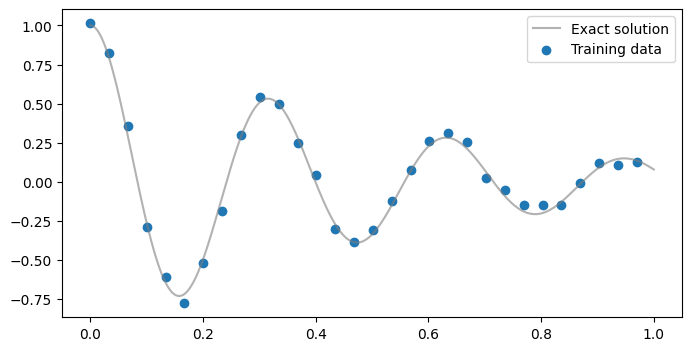

In [38]:
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'][::10].values).view(-1,1)
obs_data = torch.tensor(data['observation'][::10].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true.view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

t_data_reupload = torch.tensor([[i]*n_qubits_input for i in data['t'][::10].values])

In [39]:
qmodel = Pure_QN(
    DEVICE=device,
    N_INPUT=t_data.shape[1],
    N_QUBITS=n_qubits,
    N_INPUT_WIRES=input_wires,
    N_LAYER=n_process_layers,
    N_OUTPUT_WIRES=output_wires,
    ROTATION=rotation,
    )

list(qmodel.parameters())

[Parameter containing:
 tensor([[[1.8605, 3.2457, 1.5813],
          [4.3263, 0.4648, 5.4445],
          [0.8582, 0.6439, 1.1565],
          [4.5644, 1.9808, 4.3172],
          [0.4752, 1.2355, 1.9881],
          [2.5242, 0.7450, 5.1987]],
 
         [[2.4007, 4.1500, 5.3631],
          [3.7269, 4.0007, 6.1740],
          [1.7247, 4.1367, 1.7438],
          [5.3867, 5.6506, 0.2451],
          [5.8234, 4.6417, 4.5106],
          [4.4349, 5.7532, 2.7268]],
 
         [[0.4848, 2.2401, 0.9290],
          [3.3493, 2.5550, 1.4565],
          [2.8560, 6.1179, 2.8938],
          [3.2413, 2.6516, 3.6355],
          [5.9408, 5.0627, 4.2567],
          [3.8243, 3.8824, 4.3553]],
 
         [[2.7356, 0.2218, 1.1988],
          [5.8232, 3.3294, 0.5967],
          [3.6371, 5.7374, 0.1728],
          [1.0265, 1.8904, 3.2677],
          [2.4089, 2.7964, 0.0789],
          [4.6127, 5.8991, 5.0619]],
 
         [[0.9169, 0.6091, 4.4461],
          [3.2121, 4.4294, 0.0718],
          [2.9543, 5.3572, 4.

In [40]:
list(qmodel.parameters())[0]

Parameter containing:
tensor([[[1.8605, 3.2457, 1.5813],
         [4.3263, 0.4648, 5.4445],
         [0.8582, 0.6439, 1.1565],
         [4.5644, 1.9808, 4.3172],
         [0.4752, 1.2355, 1.9881],
         [2.5242, 0.7450, 5.1987]],

        [[2.4007, 4.1500, 5.3631],
         [3.7269, 4.0007, 6.1740],
         [1.7247, 4.1367, 1.7438],
         [5.3867, 5.6506, 0.2451],
         [5.8234, 4.6417, 4.5106],
         [4.4349, 5.7532, 2.7268]],

        [[0.4848, 2.2401, 0.9290],
         [3.3493, 2.5550, 1.4565],
         [2.8560, 6.1179, 2.8938],
         [3.2413, 2.6516, 3.6355],
         [5.9408, 5.0627, 4.2567],
         [3.8243, 3.8824, 4.3553]],

        [[2.7356, 0.2218, 1.1988],
         [5.8232, 3.3294, 0.5967],
         [3.6371, 5.7374, 0.1728],
         [1.0265, 1.8904, 3.2677],
         [2.4089, 2.7964, 0.0789],
         [4.6127, 5.8991, 5.0619]],

        [[0.9169, 0.6091, 4.4461],
         [3.2121, 4.4294, 0.0718],
         [2.9543, 5.3572, 4.5990],
         [3.2563, 3.7593,

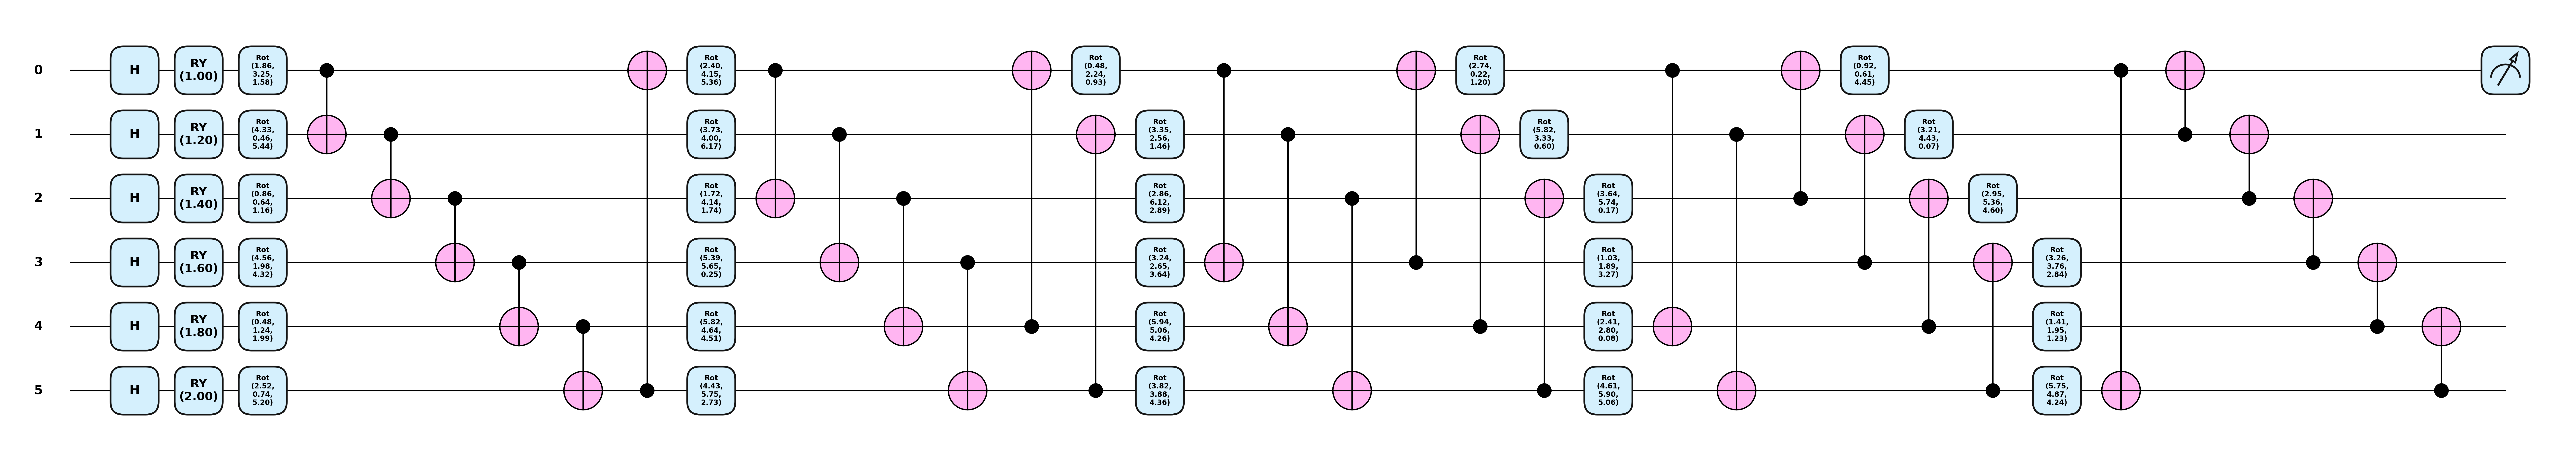

In [41]:
# Data re-uploaded to each qubits
# Measurement on the last qubit

data_in = torch.linspace(1,2, len(input_wires))
weight_in = list(qmodel.parameters())[-1]

qmodel.draw_circuit(
    data_in,
    weight_in,
    expansion_strategy='device', 
    scale=3
                    )

In [42]:
t_initial = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_data = t_data.requires_grad_(True)

t_data_reupload = t_data_reupload.requires_grad_(True)

d = 2
w0 = 20
mu = 2*d
k = w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # mu is missing, let's train it!
all_mus = []

learning_rate=1e-3
optimiser = torch.optim.Adam(list(qmodel.parameters()) + [mu], lr=learning_rate)

lambda1, lambda2 = 1e-1, 1e-5

In [43]:
t_data

tensor([[0.0000],
        [0.0334],
        [0.0669],
        [0.1003],
        [0.1338],
        [0.1672],
        [0.2007],
        [0.2341],
        [0.2676],
        [0.3010],
        [0.3344],
        [0.3679],
        [0.4013],
        [0.4348],
        [0.4682],
        [0.5017],
        [0.5351],
        [0.5686],
        [0.6020],
        [0.6355],
        [0.6689],
        [0.7023],
        [0.7358],
        [0.7692],
        [0.8027],
        [0.8361],
        [0.8696],
        [0.9030],
        [0.9365],
        [0.9699]], requires_grad=True)

In [44]:
t_data_reupload

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0334, 0.0334, 0.0334, 0.0334, 0.0334, 0.0334],
        [0.0669, 0.0669, 0.0669, 0.0669, 0.0669, 0.0669],
        [0.1003, 0.1003, 0.1003, 0.1003, 0.1003, 0.1003],
        [0.1338, 0.1338, 0.1338, 0.1338, 0.1338, 0.1338],
        [0.1672, 0.1672, 0.1672, 0.1672, 0.1672, 0.1672],
        [0.2007, 0.2007, 0.2007, 0.2007, 0.2007, 0.2007],
        [0.2341, 0.2341, 0.2341, 0.2341, 0.2341, 0.2341],
        [0.2676, 0.2676, 0.2676, 0.2676, 0.2676, 0.2676],
        [0.3010, 0.3010, 0.3010, 0.3010, 0.3010, 0.3010],
        [0.3344, 0.3344, 0.3344, 0.3344, 0.3344, 0.3344],
        [0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3679],
        [0.4013, 0.4013, 0.4013, 0.4013, 0.4013, 0.4013],
        [0.4348, 0.4348, 0.4348, 0.4348, 0.4348, 0.4348],
        [0.4682, 0.4682, 0.4682, 0.4682, 0.4682, 0.4682],
        [0.5017, 0.5017, 0.5017, 0.5017, 0.5017, 0.5017],
        [0.5351, 0.5351, 0.5351, 0.5351, 0.5351, 0.5351],
        [0.568

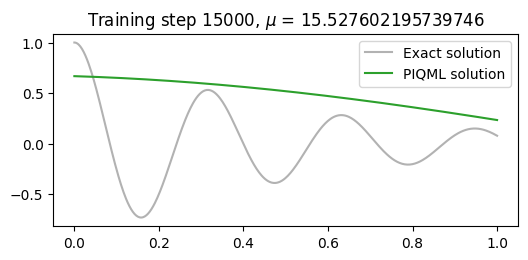

[Parameter containing:
 tensor([[[ 1.5783e+00,  1.6413e+00,  1.6451e+00],
          [ 6.2504e+00, -1.4267e+00,  6.3228e+00],
          [-1.5172e-02,  1.5089e+00,  1.6175e+00],
          [ 4.9589e+00,  2.5181e+00,  4.8847e+00],
          [ 9.0599e-01,  5.9770e-01,  2.3371e+00],
          [ 2.0666e+00, -2.3157e-02,  5.7876e+00]],
 
         [[ 9.0419e-01,  3.1912e+00,  4.0577e+00],
          [ 4.7801e+00,  3.9518e+00,  4.8871e+00],
          [ 3.0956e+00,  4.7837e+00,  1.2885e+00],
          [ 6.2165e+00,  4.7288e+00,  1.1691e+00],
          [ 6.0691e+00,  5.2588e+00,  3.4102e+00],
          [ 5.8922e+00,  6.1946e+00,  8.8855e-01]],
 
         [[ 3.3036e-03,  1.5143e+00,  1.5737e+00],
          [ 3.9886e+00,  1.5794e+00,  3.1690e+00],
          [ 2.3601e+00,  4.6922e+00,  3.1397e+00],
          [ 4.5403e+00,  3.4142e+00,  3.5022e+00],
          [ 6.2769e+00,  4.6854e+00,  4.0882e+00],
          [ 4.7259e+00,  4.7197e+00,  4.3046e+00]],
 
         [[ 2.6023e+00,  1.9264e+00, -1.0406e-01],

In [45]:
for i in range(15000):
    optimiser.zero_grad()

    # Loss function for initial conditions
    prediction = qmodel(t_initial)
    loss1, loss2 = boundary_loss(prediction, t_boundary=t_initial)

    # Physics loss with DE
    prediction = qmodel(t_data_reupload)
    loss3 = physics_loss(prediction, t_physics=t_data_reupload, mu=mu, k=k)

    # Combine loss
    loss:torch.Tensor = loss1 + lambda1*loss2 + lambda2*loss3 + mse(prediction, obs_data)

    # loss:torch.Tensor = lambda2*loss3 + mse(prediction, obs_data)

    loss.backward()

    optimiser.step()

    all_mus.append(mu.item())

    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = qmodel(t_true).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_true[:,0], prediction[:,0], label="PIQML solution", color="tab:green")
        plt.title(f"Training step {i+1}, $\mu$ = {mu.item()}")
        plt.legend()
        plt.show()
        display(list(qmodel.parameters()))


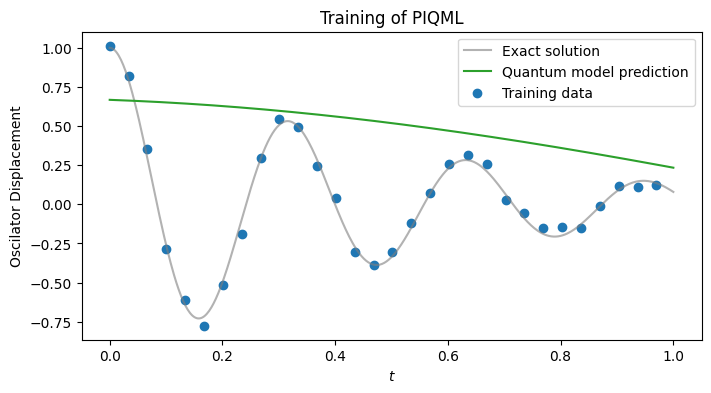

In [46]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    qmodel(t_true).detach(),
    title='Training of PIQML'
    )

mu = Parameter containing:
tensor([15.5276], requires_grad=True)


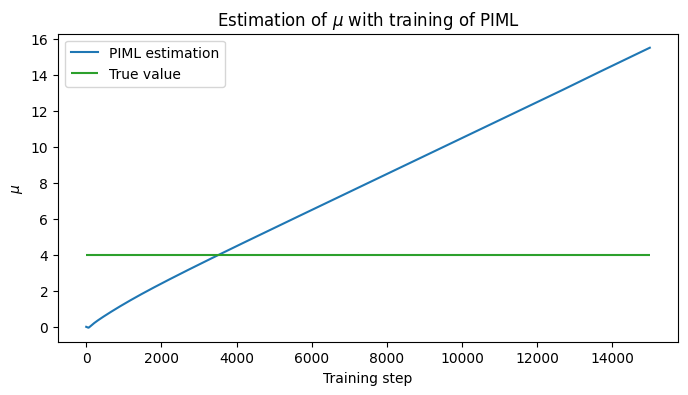

In [47]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()